# Escalamiento del radio de giro para proteínas tipo beta ($R_g \sim N^{\nu}$)

## Estructura hoja beta de las proteínas

Cuando la cadena principal de un polipéptido se estira al máximo que permiten 
sus enlaces covalentes se adopta una configuración espacial denominada estructura 
β, que suele representarse como una flecha. En esta estructura las cadenas laterales 
de los aminoácidos se sitúan de forma alternante a la derecha y a la izquierda del 
esqueleto de la cadena polipeptídica. Las estructuras β de distintas cadenas 
polipeptídicas o bien las estructuras β de distintas zonas de una misma cadena 
polipeptídica pueden interaccionar entre sí mediante puentes de hidrógeno, dando 
lugar a estructuras laminares llamadas por su forma hojas plegadas u hojas β. 


Cuando las estructuras β tienen el mismo sentido, la hoja β resultante es 
paralela, y si las estructuras β tienen sentidos opuestos, la hoja plegada resultante es 
antiparalela. 

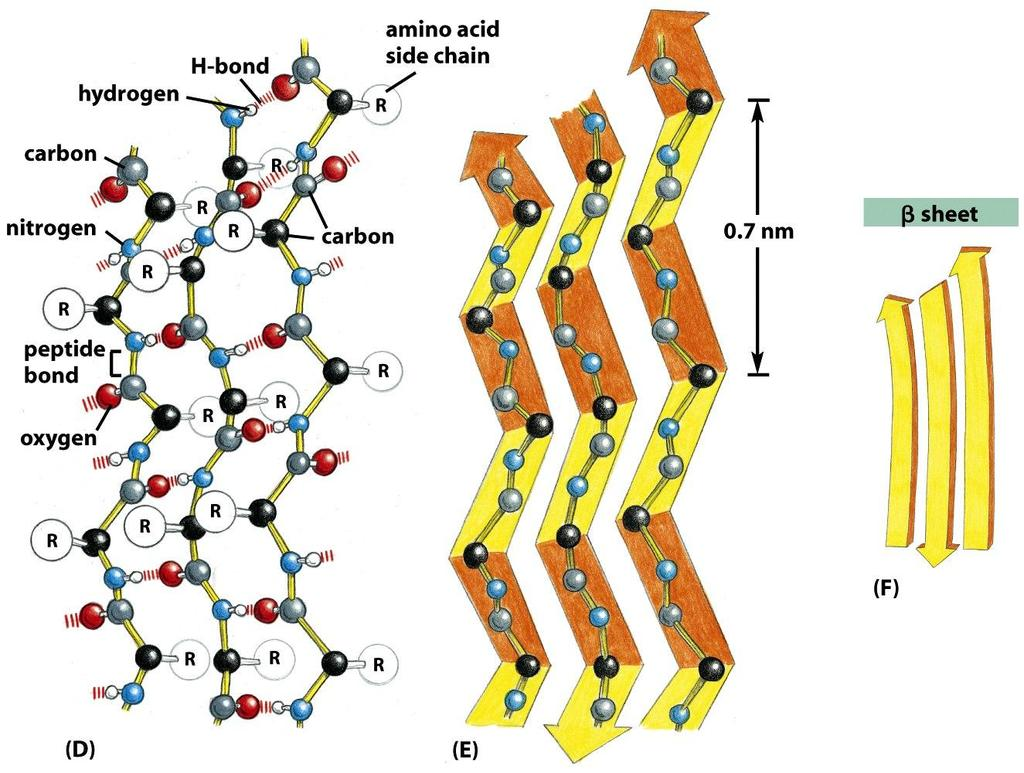

El análisis es el mismo que con las proteínas alfa hélice

In [3]:
from Bio import PDB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import os

### Funciones

In [4]:
def get_protein(ruta):
    # We get the protein structure and the global center of mass
    parser = PDB.PDBParser(QUIET=True)
    # We get the first model [0] (Crystal structures generally have only one model (with id 0), while NMR files usually have several models)
    protein = parser.get_structure('test', ruta)[0]
    CM_protein = protein.center_of_mass()
    return protein,CM_protein

Desde aquí imponemos la condición para ignorar todo lo que no sea un aminoácido con ayuda de la función:

PDB.is_aa(residue)

In [5]:
def centers_of_mass(protein):
    # We get all amino acids' centers of mass, ignoring molecules that are not amino acids (eg. water molecules)  
    CM_residues=[]
    N=0 # Length of the chain (Number of amino acids in the protein)
    for chain in protein:
        for residue in chain:
            if PDB.is_aa(residue):
                CM_residues.append(residue.center_of_mass())
                N+=1
    return CM_residues,N

In [6]:
def radius_of_gyration(CM_protein,CM_residues,N):
    # We calculate the Radius of Gyration
    suma=0
    for r in CM_residues:
        vector=[r[0]-CM_protein[0], r[1]-CM_protein[1], r[2]-CM_protein[2]]
        magnitud = vector[0]**2 + vector[1]**2 + vector[2]**2
        suma+=magnitud
    suma=suma/N
    suma+=(3/5)*((1.5)**2)
    return suma**(1/2)

### Main

In [5]:
rgyration=[]
polymerization=[]

for i in range(1,52):
    # We get alpha-helix type proteins and their center of mass
    ruta = os.path.join('..', 'data/beta', "B"+str(i)+".pdb")
    protein,CM_protein = get_protein(ruta)
    # We get the center of mass per residue per protein and polymerization (number of aminoacids N)
    CM_residue,N = centers_of_mass(protein)
    polymerization.append(N)
    # We calculate the radius of gyration of the protein
    Rg=radius_of_gyration(CM_protein,CM_residue,N)
    rgyration.append(Rg)

In [6]:
data = np.column_stack((polymerization,rgyration))
df = pd.DataFrame(data, columns=["N","Rg"])
df.head()

,N,Rg
0,1239.0,32.120996
1,352.0,19.646841
2,223.0,16.014725
3,334.0,24.186890
4,347.0,20.230588


### Graficamos nuestros datos experimentales

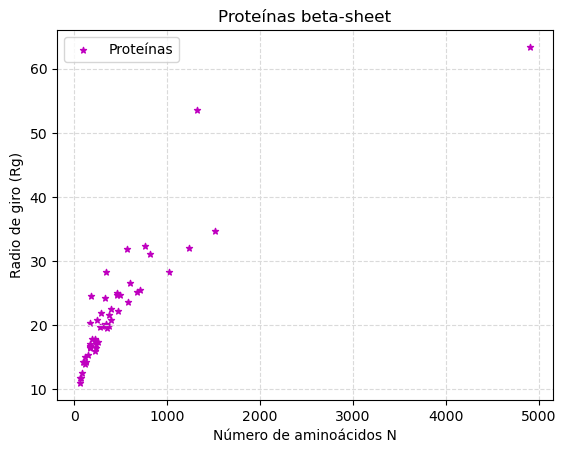

In [7]:
plt.scatter(df["N"], df["Rg"], color="m", marker='*', s=20, label="Proteínas")
plt.xlabel("Número de aminoácidos (N)")
plt.ylabel("Radio de giro (Rg)")
plt.title("Proteínas beta-sheet")
plt.grid(ls="--", color="#dadada")

plt.legend(loc=2)

plt.show()

### Vamos a ajustar todos los datos como están

In [8]:
lnData = np.log(data)
lndf = pd.DataFrame(lnData, columns=["lnN","lnRg"])
lndf.head()

,lnN,lnRg
0,7.122060,3.469510
1,5.863631,2.977917
2,5.407172,2.773509
3,5.811141,3.185811
4,5.849325,3.007196


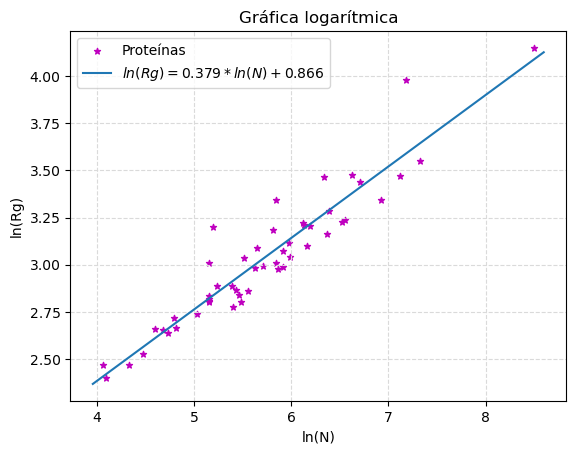

In [9]:
plt.scatter(lndf['lnN'],lndf['lnRg'], color="m", s=20, marker='*', label="Proteínas")
plt.xlabel("ln(N)")
plt.ylabel("ln(Rg)")
plt.title("Gráfica logarítmica")
plt.grid(ls="--", color="#dadada")

# Ajuste Lineal
x = np.linspace(np.min(lndf['lnN'])-0.1, np.max(lndf['lnN'])+0.1)
coeficiente = np.polyfit(lndf['lnN'],lndf['lnRg'],1)

plt.plot(x, coeficiente[0]*x + coeficiente[1], label=f"$ln(Rg)={coeficiente[0]:.3f}*ln(N) + {coeficiente[1]:.3f}$")

plt.legend()

plt.show()

In [10]:
print(f'v = {coeficiente[0]}')
print(f'b = {coeficiente[1]}')

v = 0.3791751228383952
b = 0.8658305963641721


In [11]:
model = smf.ols(formula='lnRg ~ lnN', data=lndf).fit()

# Print the full summary table
print(model.summary())

# Residual Standard Error (RSE) of the model
rse = np.sqrt(model.scale)
print(f"\nResidual Standard Error (RSE): {rse}")

                            OLS Regression Results                            
Dep. Variable:                   lnRg   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     391.7
Date:                Sun, 04 Jan 2026   Prob (F-statistic):           5.09e-25
Time:                        17:15:44   Log-Likelihood:                 37.478
No. Observations:                  51   AIC:                            -70.96
Df Residuals:                      49   BIC:                            -67.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8658      0.111      7.820      0.0

Haciendo un ajuste lineal con _statsmodels_ library obtenemos el exponente así como su incertidumbre, obteniendo que nuestros datos se comportan como:

$$Rg \sim N^{\nu}$$

donde

$$\nu = 0.379 \pm 0.019$$

Graficamos el ajuste:

$$Rg = 2.377 N^{0.379}$$

con coeficiente de correlación:

$$R^2 = 0.889$$

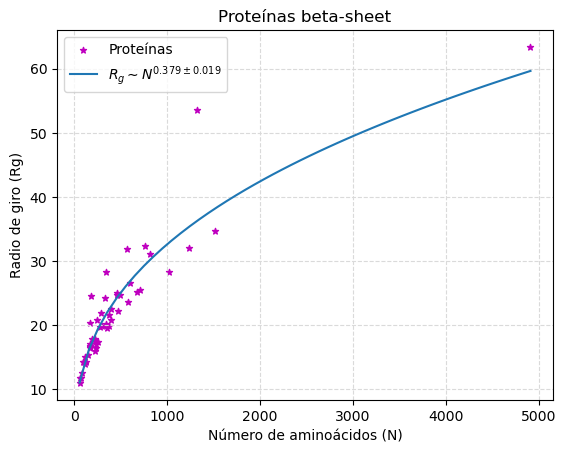

In [13]:
plt.scatter(df["N"], df["Rg"], color="m", marker='*', s=20, label="Proteínas")
plt.xlabel("Número de aminoácidos (N)")
plt.ylabel("Radio de giro (Rg)")
plt.title("Proteínas beta-sheet")
plt.grid(ls="--", color="#dadada")

x = np.linspace(np.min(df['N']), np.max(df['N']))
rg2 = np.exp(coeficiente[1])*((x)**(coeficiente[0]))
plt.plot(x,rg2,label="$R_g \sim N^{0.379 \pm 0.019}$")

plt.legend(loc=2)
plt.show()

Así, podemos concluir que según este estudio estadístico, el exponente de escalamiento del radio de giro para las proteínas tipo alfa es de

$$ \nu = 0.379 \pm 0.019 $$

## Visualización para una proteína

In [2]:
import nglview as nv
from IPython.display import display, Markdown, Image

In [7]:
# We draw a sphere with arrows
def add_rg_arrows(view, center, radius, n_theta=8, n_phi=16, color=[1, 0.6, 0], shaft_radius=0.3):

    center = np.asarray(center)

    theta_vals = np.linspace(0, np.pi, n_theta)
    phi_vals = np.linspace(0, 2*np.pi, n_phi, endpoint=False)

    for theta in theta_vals:
        for phi in phi_vals:
            direction = np.array([
                np.sin(theta) * np.cos(phi),
                np.sin(theta) * np.sin(phi),
                np.cos(theta)
            ])

            end = center + radius * direction

            view.shape.add_arrow(
                center.tolist(),
                end.tolist(),
                color,
                shaft_radius
            )

In [14]:
# Draw protein and Rg
def draw_rg(pdb_id):

    # Download the PDB file
    pdb_list = PDB.PDBList()
    pdb_file = pdb_list.retrieve_pdb_file(pdb_id, pdir=os.path.join('..', 'data/test'), file_format='pdb', overwrite=False)
    print(f'\nProtein downloaded: {pdb_id}\n')

    # Calculate CM and Rg
    print(f'Calculating CM and Rg...\n')
    structure,CM_protein = get_protein(pdb_file)
    CM_residue,N = centers_of_mass(structure)
    Rg = radius_of_gyration(CM_protein,CM_residue,N)

    # Create the view
    print(f'Creating view...\n')
    view = nv.show_file(pdb_file)

    # Protein
    view.add_cartoon()

    # Size + camera
    view.layout.width = "500px"
    view.layout.height = "500px"
    view.center()

    # CM marker
    view.shape.add_sphere(CM_protein, [0, 0, 0], 1.0)

    # Rg arrows
    add_rg_arrows(
        view,
        CM_protein,
        Rg,
        n_theta=6,
        n_phi=12,
        color=[0, 0.6, 0],
        shaft_radius=0.25
    )

    return view

In [15]:
protein_id = '1ecz'
view = draw_rg(protein_id)
view

Structure exists: '../data/test/pdb1ecz.ent' 

Protein downloaded: 1ecz

Calculating CM and Rg...

Creating view...



NGLWidget(layout=Layout(height='500px', width='500px'))

In [16]:
# Export static Image
view.render_image()
view.download_image(filename=f'rg_{protein_id}.png')

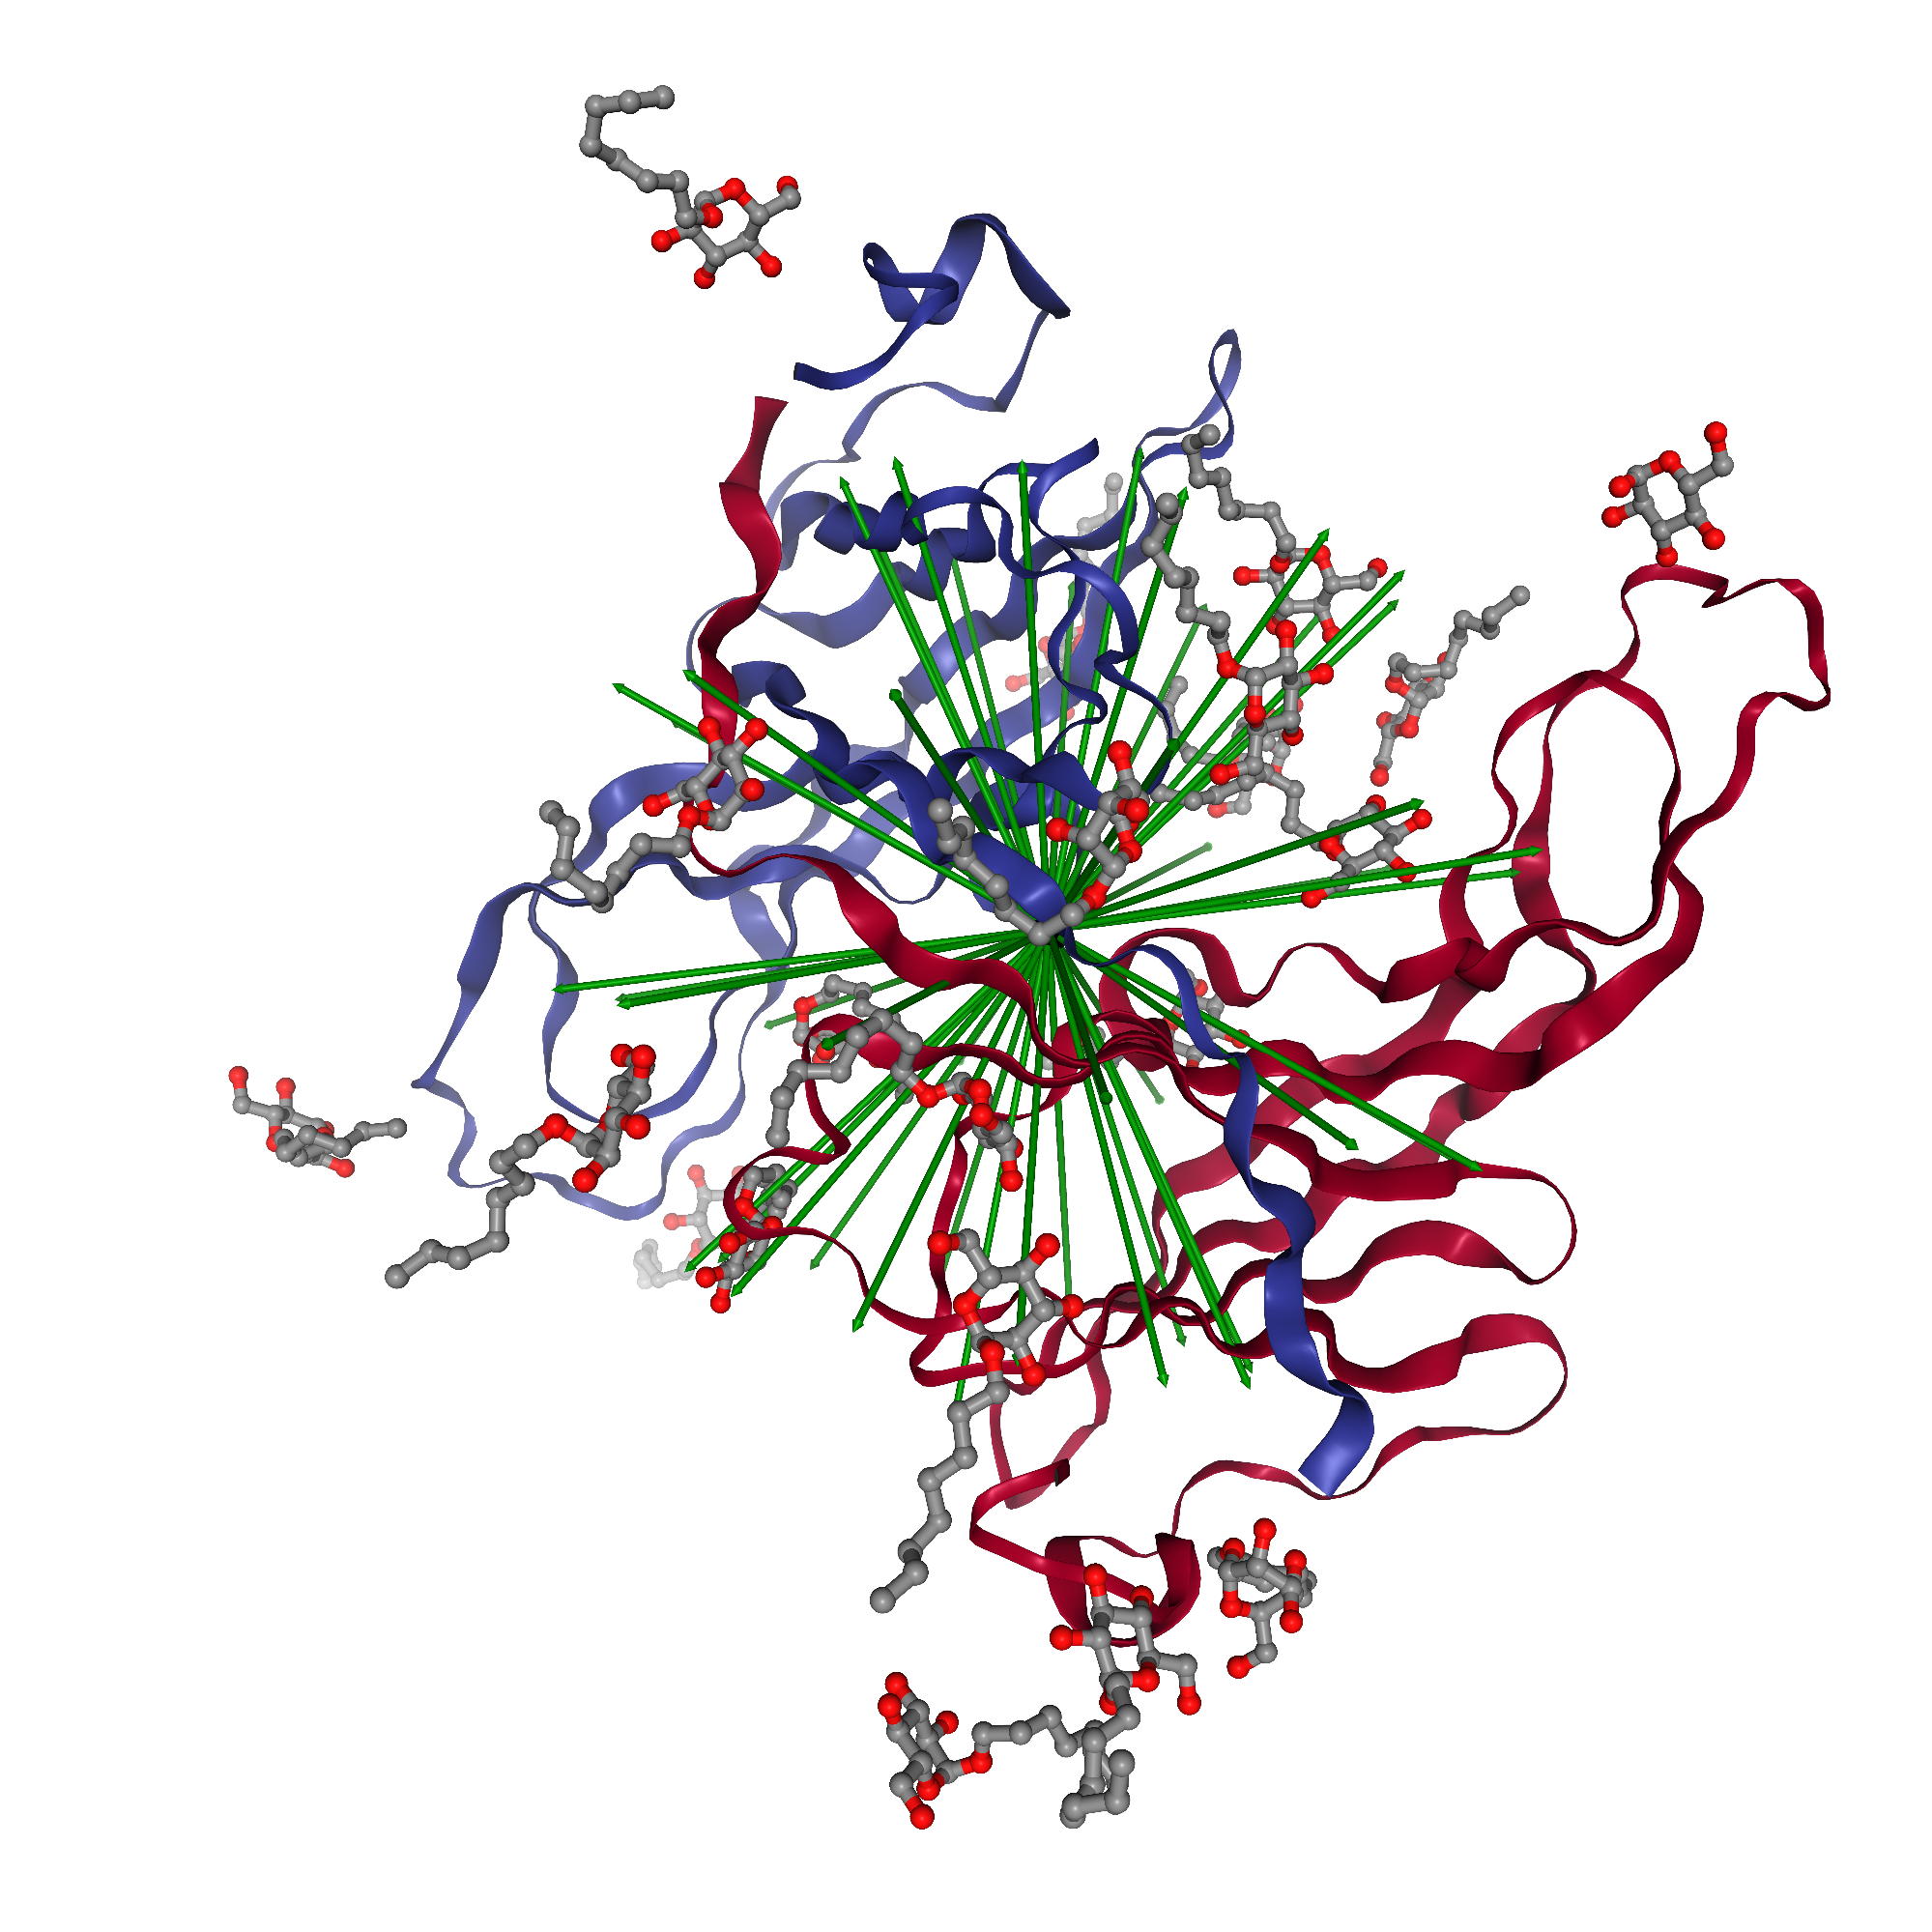

In [17]:
# Display static Image
display(Image(filename=f'rg_{protein_id}.png'))

### Try it yourself!

In [18]:
protein_id = '3est'
view = draw_rg(protein_id)
view


Protein downloaded: 3est

Calculating CM and Rg...

Creating view...



NGLWidget(layout=Layout(height='500px', width='500px'))